In [1]:
# Verificar comando actualizado en https://pytorch.org/get-started/locally/
#!pip3 install torch torchvision torchaudio
#!pip3 install matplotlib
#!pip install ipywidgets

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Dispositivo seleccionado:", device)

Dispositivo seleccionado: cuda


# Referencias
* [Learn To Pay Attention](https://arxiv.org/abs/1804.02391) Saumya Jetley, Nicholas A. Lord, Namhoon Lee, Philip H.S. Torr. Artículo original
* [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) Tutorial de PyTorch
* [Learn to pay attention model code](https://github.com/SaoYan/LearnToPayAttention/blob/master/model1.py) Código de la clase que implementa el modelo del artículo.

## Otras referencias
* [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034) Karen Simonyan, et.al.
* [Learn to pay attention](https://github.com/SaoYan/LearnToPayAttention/) Repo completo
* [Attention and image classification](https://discuss.pytorch.org/t/attention-in-image-classification/80147)
* [self-attention-gan
](https://github.com/brain-research/self-attention-gan/blob/master/model.py)


# Datos

Los conjuntos de datos de torchvision son imágenes PILImage con valores en el rango [0, 1].  Esta read utiliza tensores normalizados en el rango [-1, 1].

In [7]:
# Directorio donde se descargarán los archivos
root_dir = 'data/'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root=root_dir, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=root_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = testset.classes
img_shape = testset[0][0].shape

print("Clases:", classes)
print("Imagen:", img_shape)

Files already downloaded and verified
Files already downloaded and verified
Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Imagen: torch.Size([3, 32, 32])


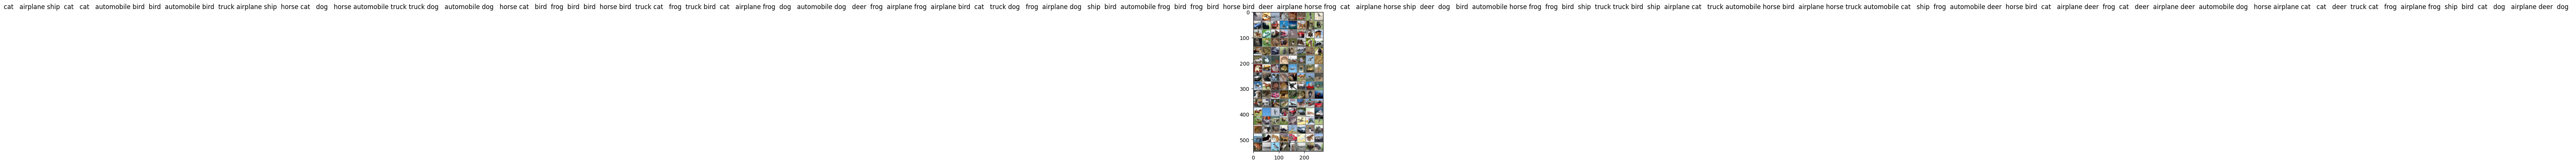

In [8]:
# functions to show an image
def imshow(img, title):
    """
    Unnormalizes img and shows it with given title.
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
batch_image = torchvision.utils.make_grid(images)
batch_labels = ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))
imshow(batch_image, batch_labels)

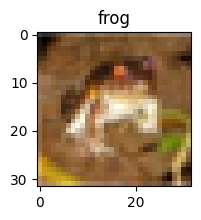

In [9]:
def muestra(index):
    plt.figure(figsize=(2,2))
    imshow(trainset[index][0], classes[trainset[index][1]])
muestra(0)

# Red

<div class="alert alert-block alert-info"> <b>Ejercicio:</b>

1. Añadir las capas de atención a esta pequeña red.
2. Entrenar y visualizar los pesos aprendidos para la función de compatibilidad.
3. Para una entrada dada visualizar los valores de activación tras calcular la función de compatibilidad.

</div>

![Convolución](figuras/Jetley.png "Atención local y global")

Idea general sobre las capas de atención local y global de Jetley.

In [10]:
class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features):
        super(LinearAttentionBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g) # batch_sizex1xWxH, compatibilidad por coordenada en WxH
        self.a = a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)  # normalize_attn
        g = torch.mul(a.expand_as(l), l)
        g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        return c.view(N,1,W,H), g

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)     # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)      # Operación común entre convoluciones
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)       # Capa a reemplazar
        self.classify = nn.Linear(84*2, 10) # Nueva capa de clasificacion 2 attn

        # En vez de aplanar
        #self.dense = nn.Conv2d(in_channels=84, out_channels=84, kernel_size=img_shape[1:]/4, padding=0, bias=True)
        # Así lo hace el código, el artículo dice que lo hicieron al revés 84 -> 6, 84 -> 16.
        self.projector1 = nn.Conv2d(in_channels=6, out_channels=84, kernel_size=1, padding=0, bias=False)
        self.projector2 = nn.Conv2d(in_channels=16, out_channels=84, kernel_size=1, padding=0, bias=False)

        # Funciones de compatibilidad
        self.att1 = LinearAttentionBlock(in_features=84)  # canales de g
        self.att2 = LinearAttentionBlock(in_features=84)

    def forward(self, x):
        #print("Forward ", x.shape)
        self.l1 = l1 = F.relu(self.conv1(x))  # batch_sizex6x28x28
        #print("l1: ", l1.shape)
        x = self.pool(l1) # /2  reduce tamaño a la mitad
        #print(x.shape)
        self.l2 = l2 = F.relu(self.conv2(x))  # batch_sizex16x10x10
        #print("l2: ", l2.shape)
        x = self.pool(l2) # /4
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        g = F.relu(self.fc2(x))              # batch_sizex84
        self.g = g = g.view(-1,84,1,1)
        #print("g: ", g.shape)

        # (compatibilidad, atención)
        l1_proy = self.projector1(l1)
        #print("l1_proy: ", l1_proy.shape)
        c1, g1 = self.att1(l1_proy, g)
        self.c1 = c1
        #print("c1: ", c1.shape)
        
        l2_proy = self.projector2(l2)
        #print("l2_proy: ", l2_proy.shape)
        c2, g2 = self.att2(l2_proy, g)
        self.c2 = c2

        # concatenación de las características nuevas,
        # ya filtradas por la atención.
        g = torch.cat((g1,g2), dim=1) # batch_sizexC
        #print("g: ", g.shape)

        # clasificación
        x = self.classify(g)                      # Se reemplaza x por g 
        return x

net = Net()

# Visualización

In [12]:
# plot(net.conv1.weight)  # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# plot(net.conv2.weight)

In [13]:
rana_batch = trainset[0][0].unsqueeze(0)
rana = net(rana_batch)

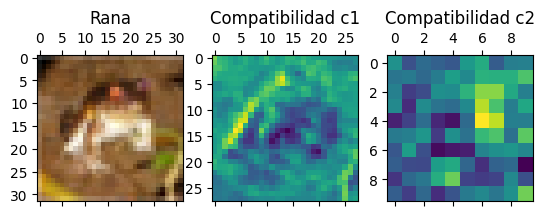

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.set_title("Rana")
ax0.matshow(np.transpose(rana_batch[0].detach().numpy() / 2 + 0.5, (1, 2, 0)))
ax1.set_title("Compatibilidad c1")
ax1.matshow(net.c1[0,0].detach().numpy())
ax2.set_title("Compatibilidad c2")
ax2.matshow(net.c2[0,0].detach().numpy())
pass

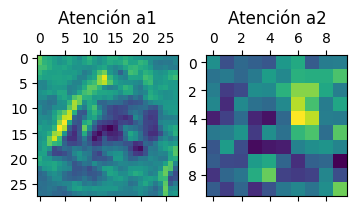

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4, 8))
ax1.set_title("Atención a1")
ax1.matshow(net.att1.a[0,0].detach().numpy())
ax2.set_title("Atención a2")
ax2.matshow(net.att2.a[0,0].detach().numpy())
pass

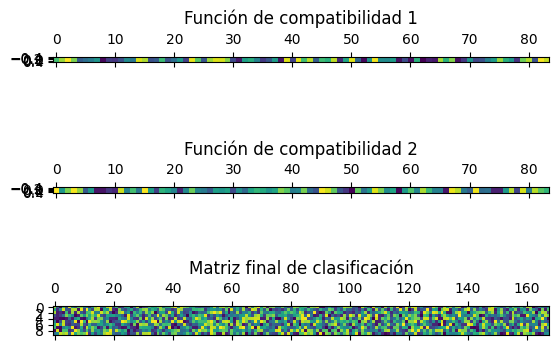

In [16]:
fig, (ax1, ax2, axg) = plt.subplots(3,1)
ax1.matshow(net.att1.op.weight[:,:,0,0].detach().numpy())
ax1.set_title("Función de compatibilidad 1")
ax2.matshow(net.att2.op.weight[:,:,0,0].detach().numpy())
ax2.set_title("Función de compatibilidad 2")
axg.matshow(net.classify.weight.detach().numpy())
axg.set_title("Matriz final de clasificación")
pass

# Evaluación

In [17]:
def exactitud(test_net, test_loader):
    # Clase por clase
    
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = test_net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Exactitud por clase: {classname:5s} is {accuracy:.1f} %')

In [18]:
exactitud(net, testloader)

Exactitud por clase: airplane is 0.2 %
Exactitud por clase: automobile is 0.0 %
Exactitud por clase: bird  is 0.0 %
Exactitud por clase: cat   is 0.1 %
Exactitud por clase: deer  is 0.0 %
Exactitud por clase: dog   is 21.5 %
Exactitud por clase: frog  is 0.0 %
Exactitud por clase: horse is 0.0 %
Exactitud por clase: ship  is 85.6 %
Exactitud por clase: truck is 0.0 %


# Entrenamiento

In [19]:
import torch.optim as optim

def train(train_net, train_loader):
    
    criterion = nn.CrossEntropyLoss()
    optimizerSGD1 = optim.SGD(train_net.parameters(), lr=0.1, momentum=0.9)
    optimizerSGD2 = optim.SGD(train_net.parameters(), lr=0.01, momentum=0.9)
    optimizerSGD3 = optim.SGD(train_net.parameters(), lr=0.001, momentum=0.9)
    optimizers = [optimizerSGD3]
    #optimizers = [optimizerSGD1, optimizerSGD2]
    
    #optimizer = optim.SGD(train_net.parameters(), lr=0.0000001, momentum=0.9, weight_decay=0.0005)
    #optimizer = torch.optim.Adam(train_net.parameters(), lr=0.0000001)

    for optimizer in optimizers:
        num_mini = 100          # print every 200 mini-batches
        for epoch in range(2):  # loop over the dataset multiple times
    
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
    
                # zero the parameter gradients
                optimizer.zero_grad()
    
                # forward + backward + optimize
                outputs = train_net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                # print statistics
                running_loss += loss.item()
                if i % num_mini == num_mini - 1:    # print every num mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / num_mini))
                    running_loss = 0.0

    print('Finished Training')

In [20]:
def preprocess(x, y):
    return x.to(device), y.to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl = WrappedDataLoader(trainloader, preprocess)
test_dl = WrappedDataLoader(testloader, preprocess)

In [21]:
net_2 = Net()
net_2 = net_2.to(device)

In [22]:
# Descomenta para entrenar
#train(net_2, train_dl)

In [22]:
PATH = 'data/cifar_net.pth'
# Descomenta para cargar
r = net_2.load_state_dict(torch.load(PATH))
net_2.to(device)
print(r)

<All keys matched successfully>


In [23]:
exactitud(net_2, test_dl)

Exactitud por clase: airplane is 55.1 %
Exactitud por clase: automobile is 67.0 %
Exactitud por clase: bird  is 36.8 %
Exactitud por clase: cat   is 31.6 %
Exactitud por clase: deer  is 35.2 %
Exactitud por clase: dog   is 43.1 %
Exactitud por clase: frog  is 69.2 %
Exactitud por clase: horse is 58.6 %
Exactitud por clase: ship  is 58.8 %
Exactitud por clase: truck is 49.0 %


In [24]:
# Descomenta para guardar
#torch.save(net_2.state_dict(), PATH)

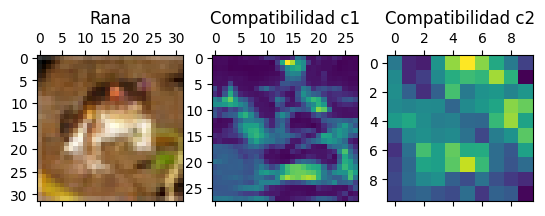

In [25]:
rana_batch_cuda = rana_batch.to(device)
rana_cuda = net_2(rana_batch_cuda)

fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.set_title("Rana")
ax0.matshow(np.transpose(rana_batch[0].cpu().detach().numpy() / 2 + 0.5, (1, 2, 0)))
ax1.set_title("Compatibilidad c1")
ax1.matshow(net.c1[0,0].cpu().detach().numpy())
ax2.set_title("Compatibilidad c2")
ax2.matshow(net.c2[0,0].cpu().detach().numpy())
pass

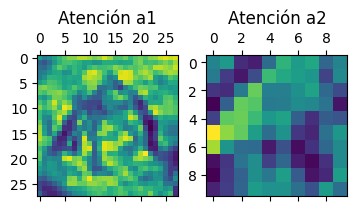

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4, 8))
ax1.set_title("Atención a1")
ax1.matshow(net_2.att1.a[0,0].cpu().detach().numpy())
ax2.set_title("Atención a2")
ax2.matshow(net_2.att2.a[0,0].cpu().detach().numpy())
pass